In [1]:
####################################################################################
## The purpose of this script is to bring together all scientometric indicators into single data structure
## i.e. We will merge bibliometric, altmetric, network scientific metric, and corpus thematic metric indicators
##
## Note: we will aggregate all metric to level of individual authors
##
## We will then explore correlation amongst these indicators in our database
##
## Author: Christopher Meaney
## Date: January 2023
####################################################################################

In [2]:
## Dependency packages --- used for plotting 
library(ggplot2)
library(viridis)

Loading required package: viridisLite



In [3]:
## Option to print more rows/columns in Jupyter Notebook
options(repr.matrix.max.cols=100, repr.matrix.max.rows=100)

In [4]:
################################
## Import the corpus of primary care research articles
## Note: these are non-unique (and may contain duplicates if two authors in study co-authored a single publication)
## We will handle issues related to non-uniqueness later in the script
################################

In [5]:
## Set working directory path
wd_path <- "Enter_a_Path_to_a_Working_Directory_For_This_Project"

scopus_fpath_sm <- paste0(wd_path, "//Core_Scopus_Dataset_Sm.csv")

scopus_df <- read.csv(scopus_fpath_sm, header=TRUE, sep=",", stringsAsFactors=FALSE)
str(scopus_df)

'data.frame':	18874 obs. of  25 variables:
 $ au_id         : num  1e+10 1e+10 1e+10 1e+10 1e+10 ...
 $ prism_url     : chr  "https://api.elsevier.com/content/abstract/scopus_id/85140976962" "https://api.elsevier.com/content/abstract/scopus_id/85121747496" "https://api.elsevier.com/content/abstract/scopus_id/85112107056" "https://api.elsevier.com/content/abstract/scopus_id/85118672412" ...
 $ eid           : chr  "2-s2.0-85140976962" "2-s2.0-85121747496" "2-s2.0-85112107056" "2-s2.0-85118672412" ...
 $ doi           : chr  "10.1016/j.socscimed.2022.115463" "10.1111/add.15760" "10.1016/j.socscimed.2021.114262" "10.3399/BJGP.2021.0195" ...
 $ issn          : chr  "02779536" "09652140" "02779536" "09601643" ...
 $ eissn         : chr  "18735347" "13600443" "18735347" "14785242" ...
 $ pub_title     : chr  "Brief opportunistic interventions by general practitioners to promote smoking cessation: A conversation analytic study" "The old and familiar meets the new and unknown: patient and clin

In [6]:
## Some differing takes on the number of unique articles
list(
    length(unique(scopus_df$doi)),
    length(unique(scopus_df$eid)),
    length(unique(scopus_df$pub_title))
)

[[1]]
[1] 13093

[[2]]
[1] 13098

[[3]]
[1] 13047

In [7]:
list(
    sum(is.na(scopus_df$doi)),
    sum(is.na(scopus_df$eid)),
    sum(is.na(scopus_df$pub_title))
)

[[1]]
[1] 0

[[2]]
[1] 0

[[3]]
[1] 0

In [8]:
## These are the primary care researchers/authors queried from the N=17 sites (and these are their unique ScopusIDs)
## See for example (https://www.scopus.com/authid/detail.uri?authorId=)
length(unique(scopus_df$au_id))

[1] 591

In [9]:
##
## Subset above dataset to only include some interesting features
##

In [10]:
keep_vars <- c("doi", 
               "au_id", 
               "au_name", 
               "au_institution",
               "au_country",
               "pub_title",
               "pub_abstract",
               "issn",
               "eissn",
               "cited_count"
               )

scopus_df_sm <- scopus_df[, keep_vars]
str(scopus_df_sm)

'data.frame':	18874 obs. of  10 variables:
 $ doi           : chr  "10.1016/j.socscimed.2022.115463" "10.1111/add.15760" "10.1016/j.socscimed.2021.114262" "10.3399/BJGP.2021.0195" ...
 $ au_id         : num  1e+10 1e+10 1e+10 1e+10 1e+10 ...
 $ au_name       : chr  "RebeccaBarnes" "RebeccaBarnes" "RebeccaBarnes" "RebeccaBarnes" ...
 $ au_institution: chr  "Oxford" "Oxford" "Oxford" "Oxford" ...
 $ au_country    : chr  "UK" "UK" "UK" "UK" ...
 $ pub_title     : chr  "Brief opportunistic interventions by general practitioners to promote smoking cessation: A conversation analytic study" "The old and familiar meets the new and unknown: patient and clinician perceptions on e-cigarettes for smoking r"| __truncated__ "Patients’ use of the internet to negotiate about treatment" "Factors affecting the documentation of spoken safety-netting advice in routine GP consultations: A cross-sectional study" ...
 $ pub_abstract  : chr  "Very brief opportunistic interventions for smoking cessation are ef

In [11]:
##
## Split dataframe by Scopus AuthorID; and sum over articles and citations
##

In [12]:
scopus_df_sm_au <- split(scopus_df_sm, f=as.factor(scopus_df_sm$au_id))
length(scopus_df_sm_au)

au_id <- names(scopus_df_sm_au)
au_num_pubs <- sapply(scopus_df_sm_au, nrow)
au_num_cites <- sapply(scopus_df_sm_au, function(x) sum(x[["cited_count"]]))

au_biblio_df <- data.frame(au_id=au_id, num_pubs=au_num_pubs, num_cites=au_num_cites)
str(au_biblio_df)

[1] 591

'data.frame':	591 obs. of  3 variables:
 $ au_id    : chr  "6504143605" "6506248480" "6506388286" "6506559674" ...
 $ num_pubs : int  18 54 89 21 6 165 27 6 10 10 ...
 $ num_cites: int  271 436 621 207 23 1453 308 103 56 70 ...


In [13]:
################################
## Import topical summary vectors of primary care abstract corpus
################################

In [14]:
fpath_theta <- paste0(wd_path, "\\NMF_X_theta.csv")

topic_vectors <- read.csv(file=fpath_theta, header=TRUE, sep=",", stringsAsFactors=FALSE)
#str(topic_vectors)

In [15]:
list(
nrow(topic_vectors),
length(unique(topic_vectors$doi))
)

[[1]]
[1] 12276

[[2]]
[1] 12273

In [16]:
topic_vectors_sm <- topic_vectors[!(duplicated(topic_vectors$doi)), ]
nrow(topic_vectors_sm)

[1] 12273

In [17]:
keep_vars <- c("doi", names(topic_vectors_sm)[grepl(x=names(topic_vectors_sm), pattern="Topic")])
topic_vectors_sm_ <- topic_vectors_sm[, keep_vars]
#str(topic_vectors_sm_)

In [18]:
## Check that all the vectors are compositional/probability vectors
table(rowSums(topic_vectors_sm_[,-1]))


    1 
12273 

In [19]:
## Merge the topic vectors with a small version of the scopus dataFrame constructed above
scopus_df_sm_ <- scopus_df_sm[,c("au_id","doi")]
dim(scopus_df_sm_)

[1] 18874     2

In [20]:
scopus_df_sm_topics <- merge(x=scopus_df_sm_, y=topic_vectors_sm_, by="doi", all.x=TRUE)
dim(scopus_df_sm_topics)

[1] 18874    62

In [21]:
## Delete the DOI vector --- we don't need it anymore
scopus_df_sm_topics$doi <- NULL

In [22]:
## Split the dataFrame by ScopusID and average the topical vectors by author
scopus_df_sm_topics_split <- split(scopus_df_sm_topics, f=as.factor(scopus_df_sm_topics$au_id))
length(scopus_df_sm_topics_split)

[1] 591

In [23]:
au_avg_topics_df <- data.frame(do.call("rbind", lapply(scopus_df_sm_topics_split, function(x) colMeans(x[,-1], na.rm=TRUE))))
names(au_avg_topics_df) <- paste0("Topic", 1:ncol(au_avg_topics_df))
au_avg_topics_df$au_id <- rownames(au_avg_topics_df)
rownames(au_avg_topics_df) <- NULL
#str(au_avg_topics_df)

In [24]:
## Do a check that the topical vectors are compositional/probabilistic vectors
table(rowSums(au_avg_topics_df[,-ncol(au_avg_topics_df)]), useNA="always")


   1  NaN <NA> 
 590    1    0 

In [25]:
##
## Import the topical vectors characterizing the corpus
##

In [26]:
fpath_phi <- paste0(wd_path, "\\NMF_phi.csv")
phi <- read.csv(file=fpath_phi, header=TRUE, sep=",", stringsAsFactors=FALSE)

dim(phi)

[1]    60 48821

In [27]:
## Normalize rows of phi to be compositional/probability vectors
phi_ <- phi/rowSums(phi)

table(rowSums(phi_))


 1 
60 

In [28]:
## Get the words which best describe the latent constructs of the corpus
topics_list <- list()

k <- nrow(phi_)

for (i in 1:k) {
    ## Get topic vector i
    tmp <- data.frame(t(phi_[i, ]))
    names(tmp) <- "probs"
    tmp$words <- rownames(tmp)
    tmp_ <- head(with(tmp, tmp[order(-probs), ]), 5)
    ## Get top-words and provs associated with the latent topic
    words <- tmp_$words
    probs <- round(tmp_$probs, 2)
    ## Combine words and probs together
    out_vec <- paste0(words, " (", probs, ")")
    ## Put into topics list 
    topics_list[[i]] <- out_vec
}

In [29]:
## List the topics to characterize the corpus
topics_list

[[1]]
[1] "outcomes (0.23)"  "outcome (0.02)"   "secondary (0.01)" "birth (0.01)"    
[5] "maternal (0.01)" 

[[2]]
[1] "smoking (0.12)"   "cessation (0.06)" "tobacco (0.03)"   "quit (0.02)"     
[5] "smokers (0.02)"  

[[3]]
[1] "studies (0.17)"  "included (0.03)" "bias (0.01)"     "reported (0.01)"
[5] "criteria (0.01)"

[[4]]
[1] "people (0.22)"     "living (0.01)"     "population (0.01)"
[4] "aged (0.01)"       "prison (0.01)"    

[[5]]
[1] "practice (0.09)"   "physicians (0.06)" "practices (0.05)" 
[4] "family (0.03)"     "physician (0.02)" 

[[6]]
[1] "risk (0.24)"           "cvd (0.02)"            "increased (0.01)"     
[4] "cardiovascular (0.01)" "individuals (0.01)"   

[[7]]
[1] "bp (0.11)"           "hypertension (0.06)" "mmhg (0.02)"        
[4] "sbp (0.01)"          "hg (0.01)"          

[[8]]
[1] "decision (0.1)"   "decisions (0.02)" "aid (0.02)"       "aids (0.02)"     
[5] "sdm (0.02)"      

[[9]]
[1] "patient (0.17)"       "engagement (0.02)"    "experience (0.01)"   
[4] "clinicians (0.01)"    "communication (0.01)"

[[10]]
[1] "data (0.24)"       "collected (0.01)"  "sources (0.01)"   
[4] "collection (0.01)" "methods (0.01)"   

[[11]]
[1] "health (0.29)"     "public (0.02)"     "population (0.01)"
[4] "systems (0.01)"    "digital (0.01)"   

[[12]]
[1] "patients (0.29)" "received (0.01)" "treated (0)"     "total (0)"      
[5] "emergency (0)"  

[[13]]
[1] "review (0.05)"     "systematic (0.03)" "reviews (0.02)"   
[4] "included (0.02)"   "literature (0.02)"

[[14]]
[1] "diabetes (0.18)" "type (0.05)"     "hbac (0.02)"     "control (0.01)" 
[5] "distress (0.01)"

[[15]]
[1] "intervention (0.18)" "control (0.03)"      "feasibility (0.01)" 
[4] "randomized (0.01)"   "change (0.01)"      

[[16]]
[1] "time (0.11)"      "days (0.02)"      "median (0.01)"    "sedentary (0.01)"
[5] "diagnosis (0.01)"

[[17]]
[1] "rates (0.07)"     "visits (0.04)"    "rate (0.02)"      "emergency (0.02)"
[5] "incidence (0.01)"

[[18]]
[1] "primary (0.34)"   "care (0.03)"      "secondary (0.02)" "outcome (0.02)"  
[5] "practices (0.01)"

[[19]]
[1] "study (0.31)"     "design (0.01)"    "assess (0.01)"    "period (0.01)"   
[5] "objective (0.01)"

[[20]]
[1] "children (0.11)"  "asthma (0.02)"    "parents (0.02)"   "child (0.02)"    
[5] "childhood (0.01)"

[[21]]
[1] "factors (0.14)"    "identify (0.01)"   "aor (0.01)"       
[4] "influence (0.01)"  "identified (0.01)"

[[22]]
[1] "cancer (0.19)"     "diagnosis (0.02)"  "cervical (0.02)"  
[4] "lung (0.02)"       "colorectal (0.02)"

[[23]]
[1] "implementation (0.1)" "strategies (0.02)"    "program (0.02)"      
[4] "framework (0.01)"     "process (0.01)"      

[[24]]
[1] "hiv (0.11)"     "living (0.02)"  "testing (0.02)" "art (0.02)"    
[5] "sexual (0.01)" 

[[25]]
[1] "evidence (0.12)" "trials (0.05)"   "rr (0.02)"       "adverse (0.02)" 
[5] "effects (0.02)" 

[[26]]
[1] "compared (0.08)"   "odds (0.03)"       "adjusted (0.02)"  
[4] "ratio (0.02)"      "confidence (0.02)"

[[27]]
[1] "social (0.17)"       "media (0.02)"        "risks (0.01)"       
[4] "assistance (0.01)"   "determinants (0.01)"

[[28]]
[1] "costs (0.08)"             "cost (0.04)"             
[3] "healthcare (0.02)"        "total (0.02)"            
[5] "costeffectiveness (0.02)"

[[29]]
[1] "interventions (0.2)"  "effective (0.01)"     "trials (0.01)"       
[4] "effectiveness (0.01)" "change (0.01)"       

[[30]]
[1] "mortality (0.13)" "allcause (0.02)"  "death (0.02)"     "deaths (0.02)"   
[5] "cvd (0.01)"      

[[31]]
[1] "women (0.16)"         "pregnancy (0.03)"     "pregnant (0.01)"     
[4] "birth (0.01)"         "contraceptive (0.01)"

[[32]]
[1] "symptoms (0.09)"   "depression (0.05)" "anxiety (0.03)"   
[4] "depressive (0.02)" "symptom (0.02)"   

[[33]]
[1] "blood (0.1)"         "pressure (0.07)"     "systolic (0.02)"    
[4] "hg (0.02)"           "hypertension (0.02)"

[[34]]
[1] "disease (0.11)"        "chronic (0.05)"        "cardiovascular (0.02)"
[4] "kidney (0.01)"         "diseases (

In [30]:
## Put into character vector structure
topics_vec <- sapply(topics_list, paste, collapse="  ")
topics_vec

[1] "outcomes (0.23)  outcome (0.02)  secondary (0.01)  birth (0.01)  maternal (0.01)"                  
 [2] "smoking (0.12)  cessation (0.06)  tobacco (0.03)  quit (0.02)  smokers (0.02)"                     
 [3] "studies (0.17)  included (0.03)  bias (0.01)  reported (0.01)  criteria (0.01)"                    
 [4] "people (0.22)  living (0.01)  population (0.01)  aged (0.01)  prison (0.01)"                       
 [5] "practice (0.09)  physicians (0.06)  practices (0.05)  family (0.03)  physician (0.02)"             
 [6] "risk (0.24)  cvd (0.02)  increased (0.01)  cardiovascular (0.01)  individuals (0.01)"              
 [7] "bp (0.11)  hypertension (0.06)  mmhg (0.02)  sbp (0.01)  hg (0.01)"                                
 [8] "decision (0.1)  decisions (0.02)  aid (0.02)  aids (0.02)  sdm (0.02)"                             
 [9] "patient (0.17)  engagement (0.02)  experience (0.01)  clinicians (0.01)  communication (0.01)"     
[10] "data (0.24)  collected (0.01)  sources (0.01)  collection (0.01)  methods (0.01)"                  
[11] "health (0.29)  public (0.02)  population (0.01)  systems (0.01)  digital (0.01)"                   
[12] "patients (0.29)  received (0.01)  treated (0)  total (0)  emergency (0)"                           
[13] "review (0.05)  systematic (0.03)  reviews (0.02)  included (0.02)  literature (0.02)"              
[14] "diabetes (0.18)  type (0.05)  hbac (0.02)  control (0.01)  distress (0.01)"                        
[15] "intervention (0.18)  control (0.03)  feasibility (0.01)  randomized (0.01)  change (0.01)"         
[16] "time (0.11)  days (0.02)  median (0.01)  sedentary (0.01)  diagnosis (0.01)"                       
[17] "rates (0.07)  visits (0.04)  rate (0.02)  emergency (0.02)  incidence (0.01)"                      
[18] "primary (0.34)  care (0.03)  secondary (0.02)  outcome (0.02)  practices (0.01)"                   
[19] "study (0.31)  design (0.01)  assess (0.01)  period (0.01)  objective (0.01)"                       
[20] "children (0.11)  asthma (0.02)  parents (0.02)  child (0.02)  childhood (0.01)"                    
[21] "factors (0.14)  identify (0.01)  aor (0.01)  influence (0.01)  identified (0.01)"                  
[22] "cancer (0.19)  diagnosis (0.02)  cervical (0.02)  lung (0.02)  colorectal (0.02)"                  
[23] "implementation (0.1)  strategies (0.02)  program (0.02)  framework (0.01)  process (0.01)"         
[24] "hiv (0.11)  living (0.02)  testing (0.02)  art (0.02)  sexual (0.01)"                              
[25] "evidence (0.12)  trials (0.05)  rr (0.02)  adverse (0.02)  effects (0.02)"                         
[26] "compared (0.08)  odds (0.03)  adjusted (0.02)  ratio (0.02)  confidence (0.02)"                    
[27] "social (0.17)  media (0.02)  risks (0.01)  assistance (0.01)  determinants (0.01)"                 
[28] "costs (0.08)  cost (0.04)  healthcare (0.02)  total (0.02)  costeffectiveness (0.02)"              
[29] "interventions (0.2)  effective (0.01)  trials (0.01)  effectiveness (0.01)  change (0.01)"         
[30] "mortality (0.13)  allcause (0.02)  death (0.02)  deaths (0.02)  cvd (0.01)"                        
[31] "women (0.16)  pregnancy (0.03)  pregnant (0.01)  birth (0.01)  contraceptive (0.01)"               
[32] "symptoms (0.09)  depression (0.05)  anxiety (0.03)  depressive (0.02)  symptom (0.02)"             
[33] "blood (0.1)  pressure (0.07)  systolic (0.02)  hg (0.02)  hypertension (0.02)"                     
[34] "disease (0.11)  chronic (0.05)  cardiovascular (0.02)  kidney (0.01)  diseases (0.01)"             
[35] "dementia (0.14)  family (0.03)  residents (0.02)  carers (0.02)  living (0.02)"                    
[36] "age (0.1)  sex (0.01)  individuals (0.01)  cohort (0.01)  aged (0.01)"                             
[37] "physical (0.11)  activity (0.11)  sedentary (0.01)  exercise (0.01)  levels (0.01)"                
[38] "months (0.12)  baseline (0.03)  followup (0.02)  month (0.02)  difference

In [31]:
#################################
## Import the Altmetric indicators
#################################

In [32]:
alt_fpath <- paste0(wd_path, "//Altmetrics_AuthImpact_Data.csv")

alt_df <- read.csv(file=alt_fpath, header=TRUE, sep=",", stringsAsFactors=TRUE)
#str(alt_df)

In [33]:
list(
nrow(alt_df),
length(unique(alt_df$doi))
)

[[1]]
[1] 13093

[[2]]
[1] 13093

In [34]:
keep_vars <- c("doi", "tweets", "msm", "wiki", "policy")

alt_df_sm <- alt_df[,keep_vars]

alt_df_sm$tweets <- ifelse(is.na(alt_df_sm$tweets)==TRUE, 0, alt_df_sm$tweets)
alt_df_sm$msm <- ifelse(is.na(alt_df_sm$msm)==TRUE, 0, alt_df_sm$msm)
alt_df_sm$wiki <- ifelse(is.na(alt_df_sm$wiki)==TRUE, 0, alt_df_sm$wiki)
alt_df_sm$policy <- ifelse(is.na(alt_df_sm$policy)==TRUE, 0, alt_df_sm$policy)

str(alt_df_sm)

'data.frame':	13093 obs. of  5 variables:
 $ doi   : Factor w/ 13093 levels "10.1001/amajethics.2020.126",..: 3000 5825 2987 12417 12572 7311 2983 4429 12630 6140 ...
 $ tweets: num  8 33 18 31 14 15 41 41 11 0 ...
 $ msm   : num  0 1 0 0 0 0 0 0 0 0 ...
 $ wiki  : num  0 0 0 0 0 0 0 0 0 0 ...
 $ policy: num  0 0 0 0 0 0 0 0 0 0 ...


In [35]:
## Merge the topic vectors with a small version of the scopus dataFrame constructed above
scopus_df_sm_ <- scopus_df_sm[,c("au_id","doi")]
dim(scopus_df_sm_)

[1] 18874     2

In [36]:
alt_df_sm_ <- merge(x=scopus_df_sm_, y=alt_df_sm, by="doi", all.x=TRUE)
dim(alt_df_sm_)

[1] 18874     6

In [37]:
## Drop the DOI variable --- it is not needed anymore
alt_df_sm_$doi <- NULL

In [38]:
## Split the altmetrics dataFrame by ScopusID and sum altmetrics by author
alt_df_sm_split <- split(alt_df_sm_, f=as.factor(alt_df_sm_$au_id))
length(alt_df_sm_split)

[1] 591

In [39]:
au_alt_sum_df <- data.frame(do.call("rbind", lapply(alt_df_sm_split, function(x) colSums(x[,-1], na.rm=TRUE))))
names(au_alt_sum_df) <- c("tweets","msm","wiki","policy")
au_alt_sum_df$au_id <- rownames(au_alt_sum_df)
rownames(au_alt_sum_df) <- NULL
str(au_alt_sum_df)

'data.frame':	591 obs. of  5 variables:
 $ tweets: num  478 321 970 103 30 ...
 $ msm   : num  31 35 63 12 0 463 1 55 0 0 ...
 $ wiki  : num  0 0 2 1 4 1 0 0 0 0 ...
 $ policy: num  1 1 8 0 0 4 0 0 0 0 ...
 $ au_id : chr  "6504143605" "6506248480" "6506388286" "6506559674" ...


In [40]:
#################################
## Import the author metrics dataFrame --- this will be used to grab author experience data (i.e. num years research experience)
#################################

In [41]:
au_metrics_fpath <- paste0(wd_path, "//Scopus_Auth_Metrics.csv")

au_metrics <- read.csv(file=au_metrics_fpath, header=TRUE, sep=",", stringsAsFactors=TRUE)
str(au_metrics)

'data.frame':	591 obs. of  16 variables:
 $ id            : num  6.50e+09 6.51e+09 6.51e+09 6.51e+09 6.51e+09 ...
 $ au_id         : num  6.50e+09 6.51e+09 6.51e+09 6.51e+09 6.51e+09 ...
 $ doc_count     : int  35 123 142 66 52 206 83 17 22 35 ...
 $ cited_count   : int  506 2556 1375 1653 462 2195 1761 444 378 712 ...
 $ citation_count: int  693 3016 1818 1809 515 2633 2030 447 444 763 ...
 $ h_index       : int  16 29 24 18 9 27 25 8 10 15 ...
 $ coauthor_count: int  352 160 488 215 100 587 1487 201 45 91 ...
 $ pub_last      : int  2023 2023 2022 2022 2023 2023 2022 2023 2022 2020 ...
 $ pub_first     : int  1996 2003 2002 1998 1995 2003 1986 1997 1997 2004 ...
 $ affil1        : Factor w/ 117 levels "Ariadne Labs",..: NA 69 NA 69 16 NA NA 80 29 25 ...
 $ affil2        : Factor w/ 41 levels "Bhabha Atomic Research Centre",..: NA NA NA NA 27 NA NA 23 31 34 ...
 $ affil_city    : Factor w/ 37 levels "Adelaide","Ann Arbor",..: NA 30 NA 30 31 NA NA 17 37 2 ...
 $ affil_country : Factor 

In [42]:
## Compute number years research experience --- difference of last-first publication
au_metrics$years_res <- with(au_metrics, pub_last - pub_first)
table(au_metrics$years_res)


 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 
 3 12 14  9 19  7 24 13 16 18 11 27 15 16 30 23 18 15 11 13 14 15 16 13 14 17 
26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 48 49 52 53 54 
13 13 15 10  4 16 10  7 11  4  8  5  8  4  5  3  2  4  4  6  1  1  1  1  1  1 
57 72 
 2  1 

In [43]:
au_metrics_df <- au_metrics[,c("au_id","years_res")]
str(au_metrics_df)

'data.frame':	591 obs. of  2 variables:
 $ au_id    : num  6.50e+09 6.51e+09 6.51e+09 6.51e+09 6.51e+09 ...
 $ years_res: int  27 20 20 24 28 20 36 26 25 16 ...


In [44]:
#################################
## Import the network scientific indicators
#################################

In [45]:
deg_df <- read.csv(file=paste0(wd_path, "//centrality_degree.csv"), header=TRUE, sep=",", stringsAsFactors=FALSE)
names(deg_df) <- c("au_id", "cent_degree")

clo_df <- read.csv(file=paste0(wd_path, "//centrality_closeness.csv"), header=TRUE, sep=",", stringsAsFactors=FALSE)
names(clo_df) <- c("au_id", "cent_clo")

betw_df <- read.csv(file=paste0(wd_path, "//centrality_betweenness.csv"), header=TRUE, sep=",", stringsAsFactors=FALSE)
names(betw_df) <- c("au_id", "cent_betw")

pr_df <- read.csv(file=paste0(wd_path, "//centrality_pagerank.csv"), header=TRUE, sep=",", stringsAsFactors=FALSE)
names(pr_df) <- c("au_id", "cent_pr")

In [46]:
## Merge the network centrality measures with a small version of the scopus dataFrame constructed above
scopus_df_sm_ <- scopus_df_sm[!duplicated(scopus_df_sm$au_id), c("au_id"), drop=FALSE]
dim(scopus_df_sm_)

[1] 591   1

In [47]:
au_network_metrics_df <- merge(x=scopus_df_sm_, y=deg_df, by="au_id", all.x=TRUE)
au_network_metrics_df <- merge(x=au_network_metrics_df, y=clo_df, by="au_id", all.x=TRUE)
au_network_metrics_df <- merge(x=au_network_metrics_df, y=betw_df, by="au_id", all.x=TRUE)
au_network_metrics_df <- merge(x=au_network_metrics_df, y=pr_df, by="au_id", all.x=TRUE)

dim(au_network_metrics_df)

[1] 591   5

In [48]:
################################
## Merge each of the bibliometric, altmetric, network scientific metric, and topic model metric dataFrames into single structure
################################

In [49]:
X <- merge(x=au_biblio_df, y=au_metrics_df, by="au_id", all.x=TRUE)
X <- merge(x=X, y=au_alt_sum_df, by="au_id", all.x=TRUE)
X <- merge(x=X, y=au_network_metrics_df, by="au_id", all.x=TRUE)
X <- merge(x=X, y=au_avg_topics_df, by="au_id", all.x=TRUE)

dim(X)

[1] 591  72

In [50]:
str(X)

'data.frame':	591 obs. of  72 variables:
 $ au_id      : chr  "10041373600" "10240446500" "12791296200" "12804958400" ...
 $ num_pubs   : int  33 15 73 15 80 4 123 18 9 11 ...
 $ num_cites  : int  339 109 681 39 711 38 2309 5387 106 107 ...
 $ years_res  : int  18 17 16 28 19 23 17 16 16 16 ...
 $ tweets     : num  899 128 950 28 456 ...
 $ msm        : num  4 9 86 0 36 0 419 445 0 3 ...
 $ wiki       : num  0 0 1 0 2 0 57 6 0 0 ...
 $ policy     : num  1 0 3 1 1 0 20 11 1 0 ...
 $ cent_degree: int  382 148 1674 136 1622 130 2154 192 144 178 ...
 $ cent_clo   : num  0.295 0.241 0.314 0.244 0.305 ...
 $ cent_betw  : num  1411058 1543880 5992373 1664689 6714043 ...
 $ cent_pr    : num  7.19e-05 6.80e-05 1.87e-04 6.15e-05 1.87e-04 ...
 $ Topic1     : num  0.0155 0.0178 0.0294 0.0192 0.0232 ...
 $ Topic2     : num  0.039094 0 0.003442 0.000521 0.00331 ...
 $ Topic3     : num  0.0204 0.0461 0.0146 0.0153 0.0273 ...
 $ Topic4     : num  0.00735 0.01038 0.05528 0.01024 0.04028 ...
 $ Topic5  

In [51]:
##
## Investigate correlation between bibliometrics, altmetrics, and network scientific metrics (use Spearman rank correlation)
##

In [52]:
cor_vars <- c("years_res",
             "num_pubs",
             "num_cites",
             "tweets",
             "msm",
             "wiki",
             "policy",
             "cent_degree",
             "cent_betw",
             "cent_clo",
             "cent_pr")

metrics_cor_mat <- cor(X[,cor_vars], method="spearman", use="pairwise.complete.obs")
metrics_cor_mat <- round(metrics_cor_mat, 3)
metrics_cor_mat

,years_res,num_pubs,num_cites,tweets,msm,wiki,policy,cent_degree,cent_betw,cent_clo,cent_pr
years_res,1.000,0.305,0.270,0.095,0.141,0.098,0.125,0.208,0.346,0.095,0.333
num_pubs,0.305,1.000,0.859,0.755,0.693,0.492,0.639,0.889,0.842,0.555,0.935
num_cites,0.270,0.859,1.000,0.866,0.790,0.614,0.769,0.836,0.740,0.566,0.799
tweets,0.095,0.755,0.866,1.000,0.840,0.645,0.731,0.772,0.637,0.589,0.677
msm,0.141,0.693,0.790,0.840,1.000,0.592,0.682,0.712,0.585,0.479,0.645
wiki,0.098,0.492,0.614,0.645,0.592,1.000,0.574,0.506,0.458,0.426,0.457
policy,0.125,0.639,0.769,0.731,0.682,0.574,1.000,0.644,0.537,0.510,0.583
cent_degree,0.208,0.889,0.836,0.772,0.712,0.506,0.644,1.000,0.813,0.672,0.867
cent_betw,0.346,0.842,0.740,0.637,0.585,0.458,0.537,0.813,1.000,0.481,0.928
cent_clo,0.095,0.555,0.566,0.589,0.479,0.426,0.510,0.672,0.481,1.000,0.463


In [53]:
## Check min and max correlation
list(
    min(metrics_cor_mat),
    max(metrics_cor_mat)
)

[[1]]
[1] 0.095

[[2]]
[1] 1

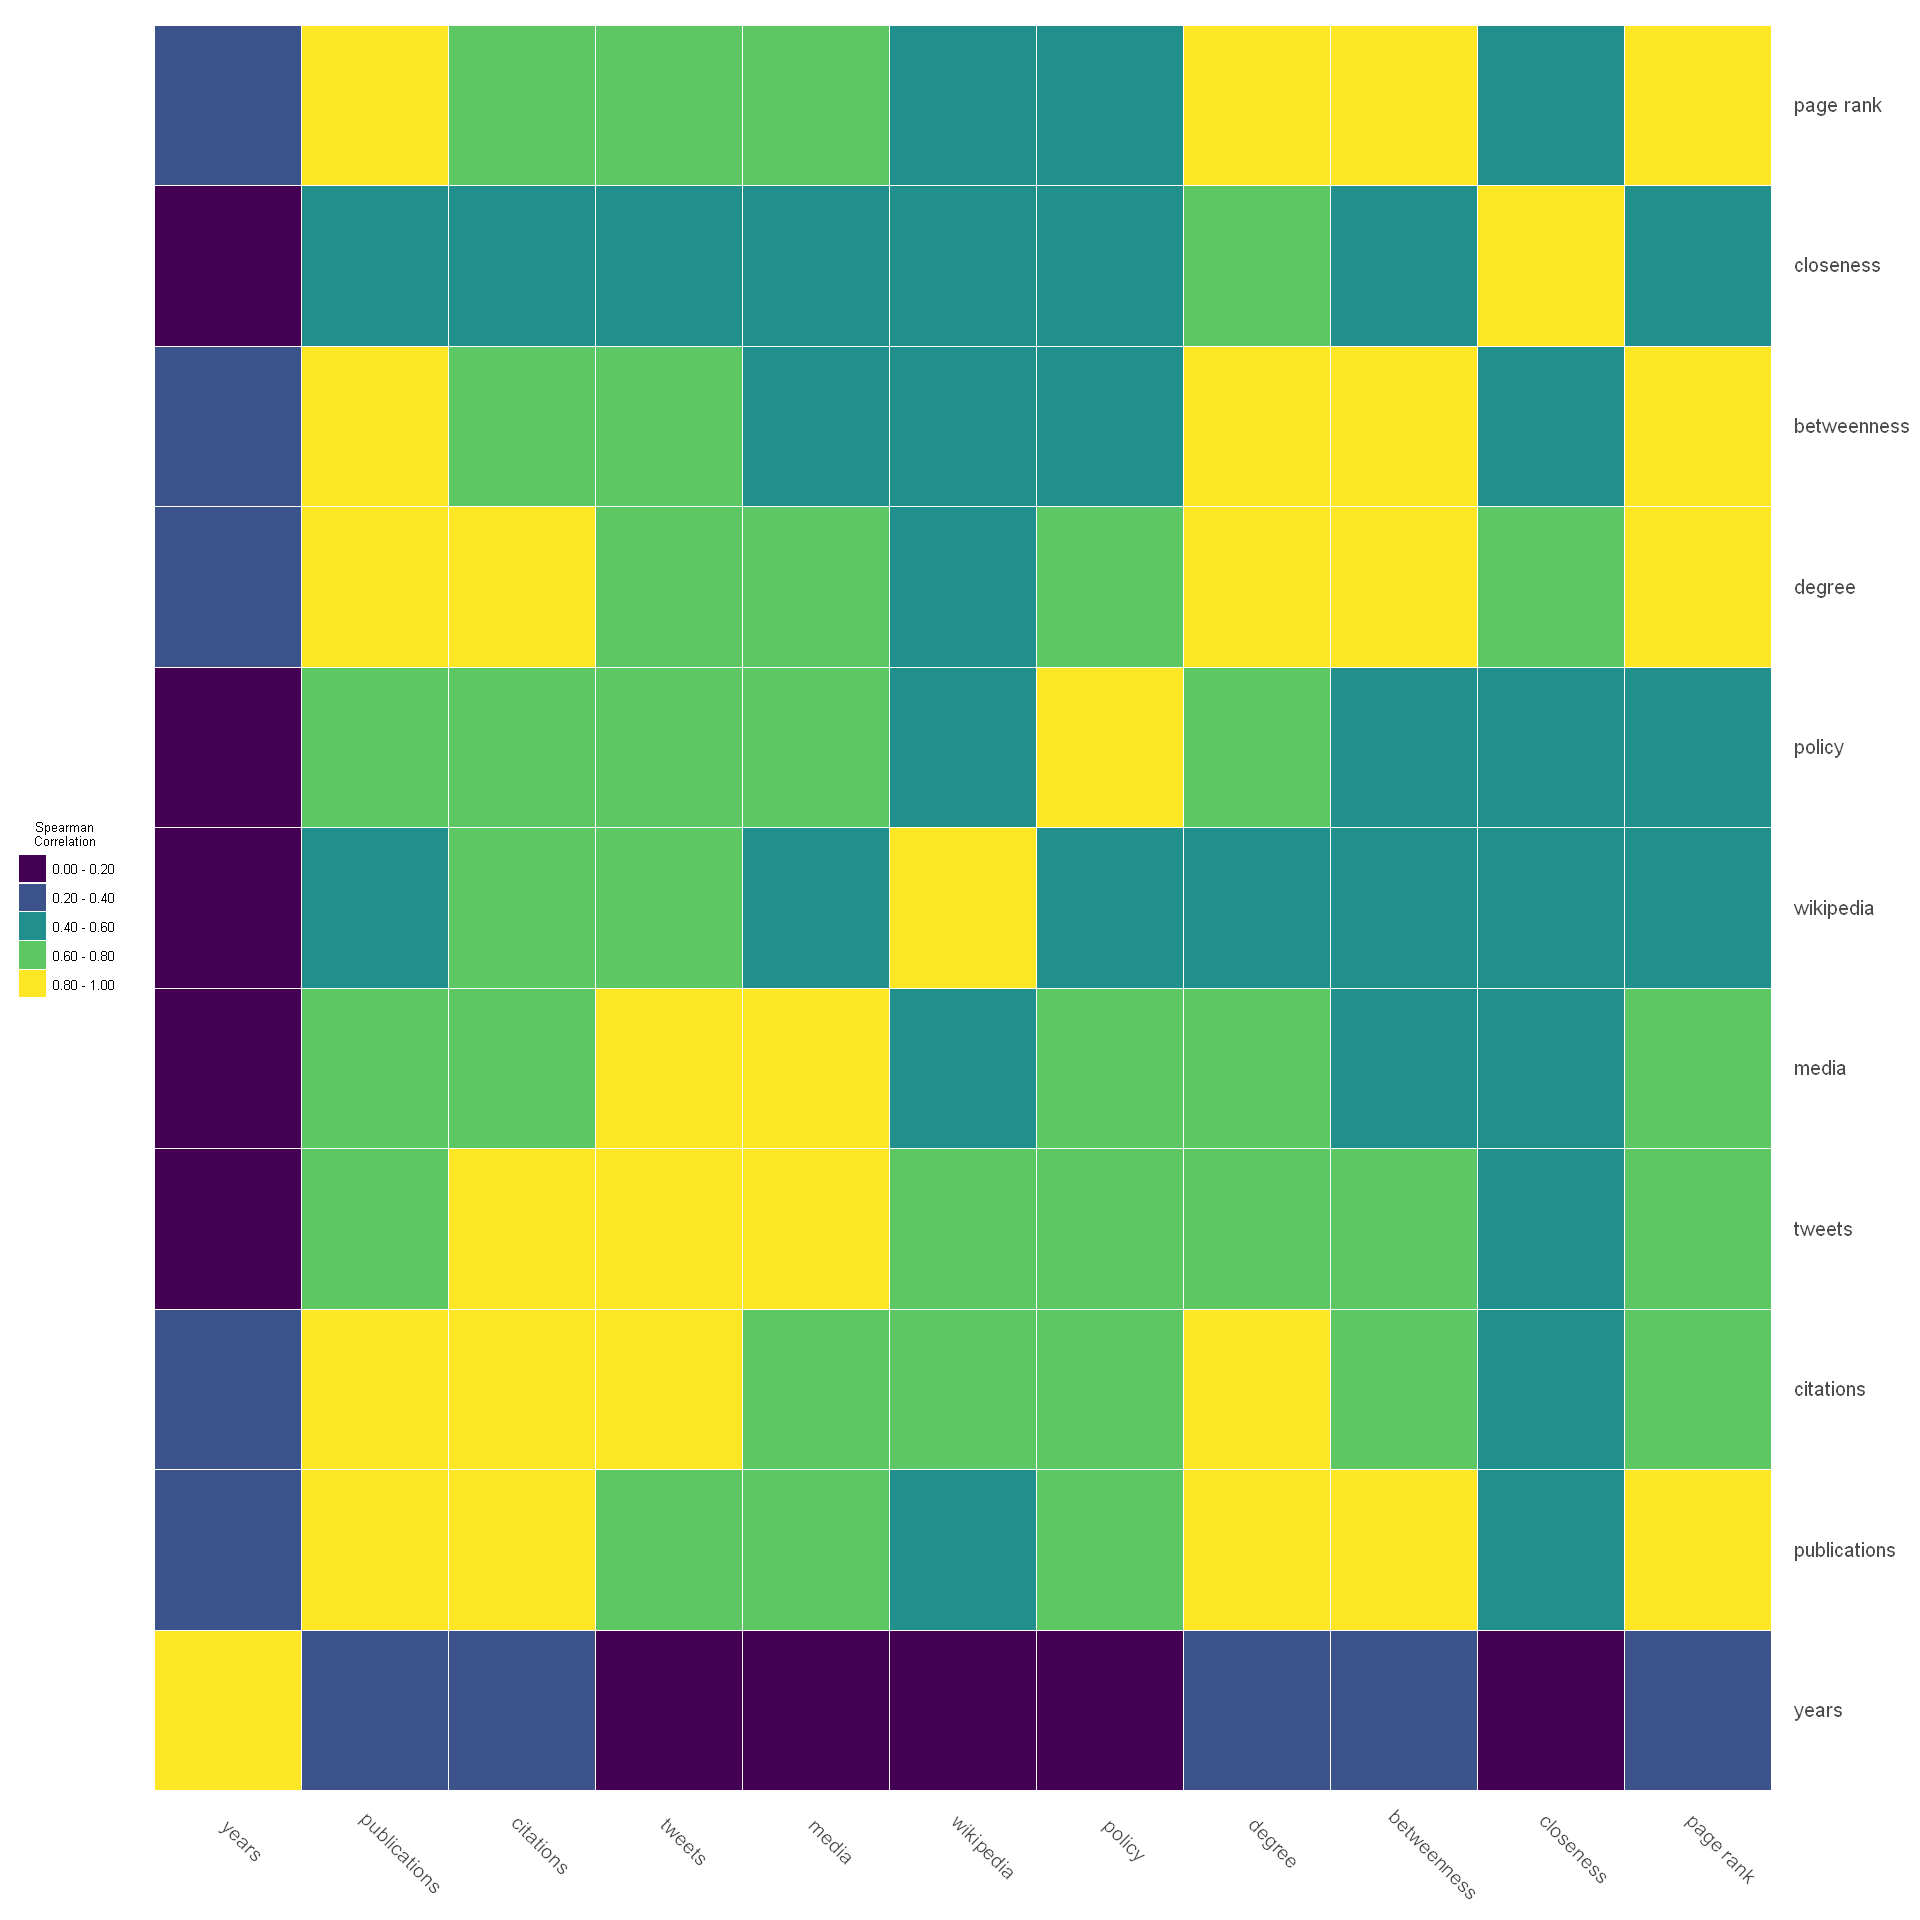

In [54]:
## Plot the correlation matrix above
options(repr.plot.width=16, repr.plot.height=16)

nams <- c("years", "publications", "citations", "tweets", "media", "wikipedia", "policy", "degree", "betweenness", "closeness", "page rank")

cor_vec <- c(metrics_cor_mat)

row_lab_vec <- rep(nams, nrow(metrics_cor_mat))
row_lab_vec <- factor(row_lab_vec, levels=nams, labels=nams)

col_lab_vec <- rep(nams, each=nrow(metrics_cor_mat))
col_lab_vec <- factor(col_lab_vec, levels=nams, labels=nams)

cor_metrics_long_df <- data.frame(col_lab=col_lab_vec, row_lab=row_lab_vec, cor_vec=cor_vec)
# cor_metrics_long_df

## Convert to factor variable --- discretizing the continuous correlations
cor_metrics_long_df$cor_ <- as.factor(cut(cor_metrics_long_df$cor, 
                              breaks=c(0, 0.2, 0.40, 0.6, 0.8, 1.0), 
                              labels=c("0.00 - 0.20", "0.20 - 0.40", "0.40 - 0.60", "0.60 - 0.80", "0.80 - 1.00")))

# table(cor_metrics_long_df$cor_)

## Plot the long format data
ggplot(cor_metrics_long_df, aes(x=row_lab, y=col_lab, fill=cor_)) +
        geom_tile(color="white") +
        scale_fill_viridis(name="Spearman\nCorrelation",
                            option="viridis",
                            discrete=TRUE,
                            labels=c("0.00 - 0.20", "0.20 - 0.40", "0.40 - 0.60", "0.60 - 0.80", "0.80 - 1.00")) +
        scale_y_discrete(position="right") +
        theme(axis.line=element_blank(),
              axis.ticks=element_blank(),
              panel.background=element_blank(),
              axis.text.x=element_text(size=12, angle=315, hjust=0.2, vjust=0),
              axis.text.y=element_text(size=12, hjust=1, vjust=0.375),
              axis.title.x=element_blank(),
              axis.title.y=element_blank(),
              legend.title=element_text(size=8, hjust=0.5),
              legend.text=element_text(size=8, vjust=0.5, hjust=0),
              legend.position="left"
             )

In [55]:
##
## Investigate correlation between above scientometrics vs. particular topics 
##

In [56]:
topic_vars <- names(X)[grepl(x=names(X), pattern="Topic")]
cor_mat <- data.frame(cor(y=X[,cor_vars], x=X[,topic_vars], method="spearman", use="pairwise.complete.obs"))
rownames(cor_mat) <- paste0("Topic ", sprintf("%02d", 1:k), ":  ", topics_vec)
cor_mat <- round(cor_mat, 3)
cor_mat

,years_res,num_pubs,num_cites,tweets,msm,wiki,policy,cent_degree,cent_betw,cent_clo,cent_pr
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Topic 01: outcomes (0.23) outcome (0.02) secondary (0.01) birth (0.01) maternal (0.01),0.076,0.168,0.157,0.153,0.184,0.143,0.123,0.184,0.189,0.098,0.197
Topic 02: smoking (0.12) cessation (0.06) tobacco (0.03) quit (0.02) smokers (0.02),0.119,0.428,0.424,0.372,0.443,0.256,0.337,0.413,0.375,0.248,0.411
Topic 03: studies (0.17) included (0.03) bias (0.01) reported (0.01) criteria (0.01),-0.029,0.216,0.247,0.219,0.128,0.216,0.188,0.153,0.160,0.238,0.147
Topic 04: people (0.22) living (0.01) population (0.01) aged (0.01) prison (0.01),-0.148,0.201,0.255,0.344,0.261,0.204,0.300,0.246,0.141,0.307,0.136
Topic 05: practice (0.09) physicians (0.06) practices (0.05) family (0.03) physician (0.02),0.095,0.040,-0.043,-0.004,-0.086,-0.026,-0.036,-0.035,0.075,0.000,0.042
Topic 06: risk (0.24) cvd (0.02) increased (0.01) cardiovascular (0.01) individuals (0.01),0.065,0.309,0.354,0.336,0.393,0.245,0.284,0.340,0.214,0.292,0.230
Topic 07: bp (0.11) hypertension (0.06) mmhg (0.02) sbp (0.01) hg (0.01),0.095,0.340,0.273,0.277,0.309,0.121,0.201,0.294,0.309,0.160,0.324
Topic 08: decision (0.1) decisions (0.02) aid (0.02) aids (0.02) sdm (0.02),0.120,0.071,0.005,-0.018,-0.129,-0.034,-0.030,0.025,0.121,0.040,0.102
Topic 09: patient (0.17) engagement (0.02) experience (0.01) clinicians (0.01) communication (0.01),0.079,0.068,-0.016,-0.011,-0.110,-0.057,-0.085,0.041,0.087,0.038,0.083


In [57]:
## Check min and max correlation
list(
    min(cor_mat),
    max(cor_mat)
)

[[1]]
[1] -0.354

[[2]]
[1] 0.443

In [58]:
##
## Plot the correlation matrix below...
##

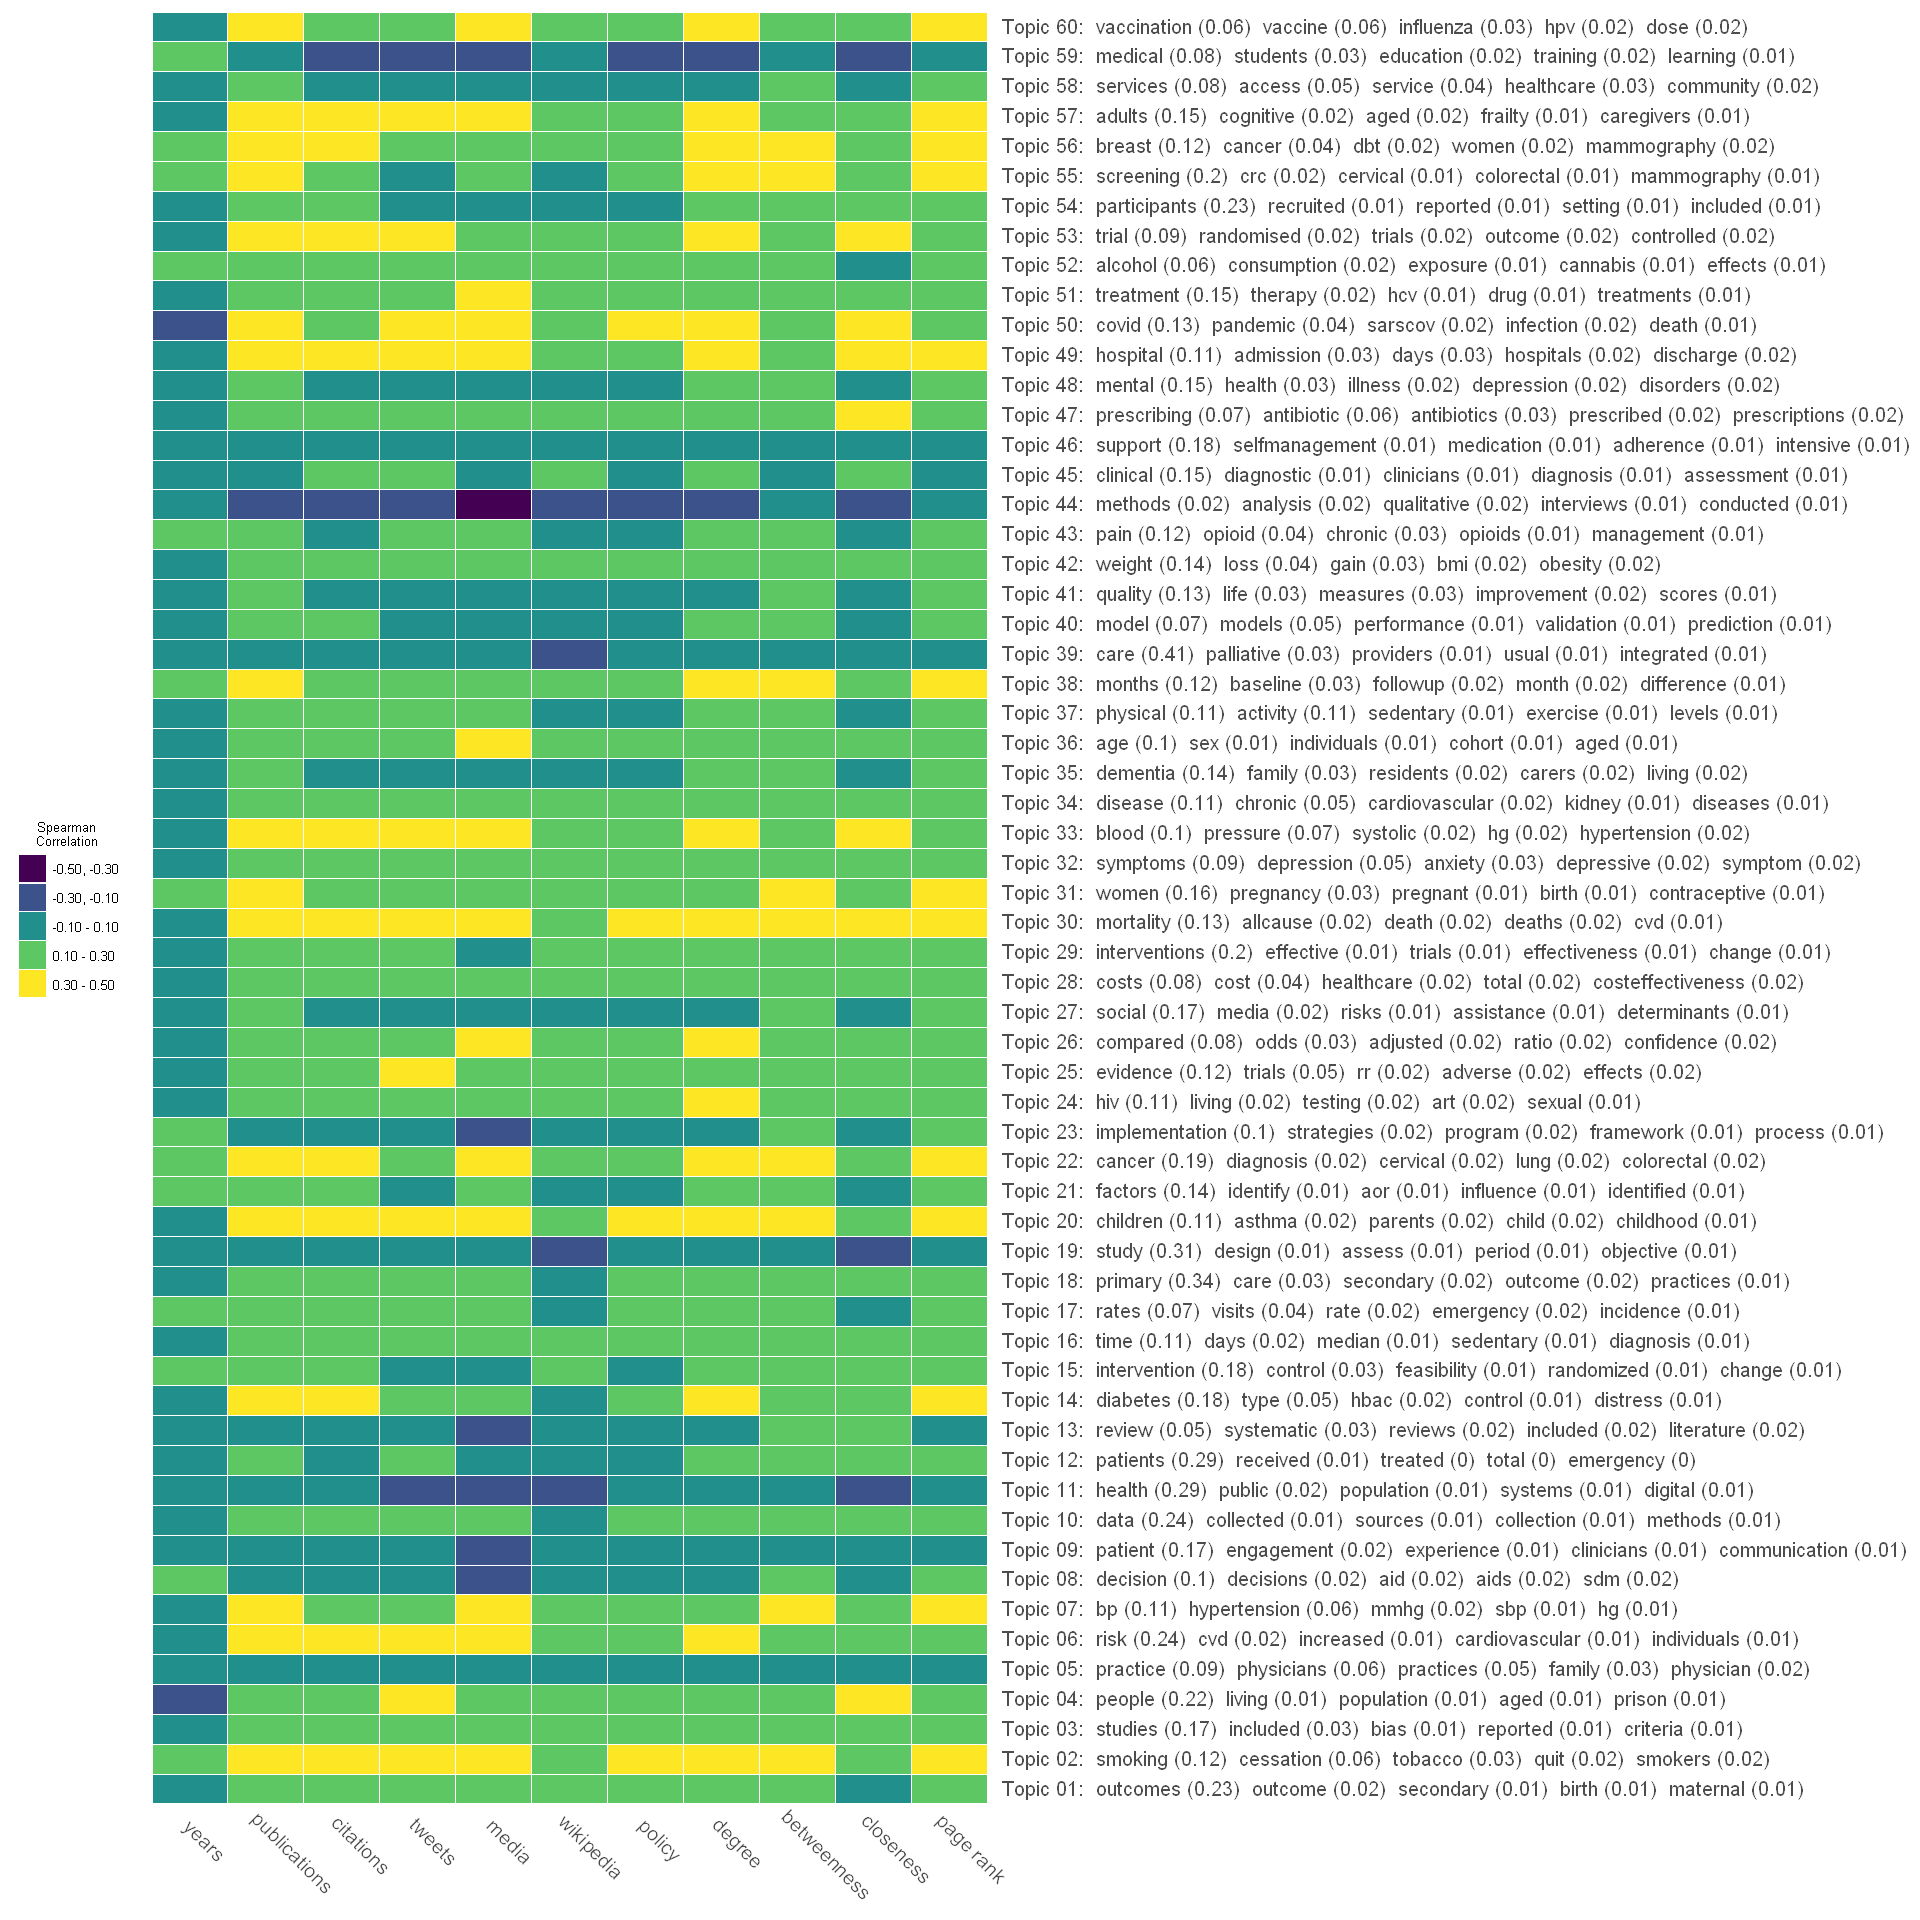

In [59]:
## Plot the correlation matrix above
options(repr.plot.width=16, repr.plot.height=16)

col_nams <- c("years", "publications", "citations", "tweets", "media", "wikipedia", "policy", "degree", "betweenness", "closeness", "page rank")
row_nams <- paste0("Topic ", sprintf("%02d", 1:k), ":  ", topics_vec)

cor_vec <- unlist(cor_mat)

row_lab_vec <- rep(row_nams, ncol(cor_mat))
row_lab_vec <- factor(row_lab_vec, levels=row_nams, labels=row_nams)

col_lab_vec <- rep(col_nams, each=nrow(cor_mat))
col_lab_vec <- factor(col_lab_vec, levels=col_nams, labels=col_nams)

cor_metrics_long_df <- data.frame(col_lab=col_lab_vec, row_lab=row_lab_vec, cor_vec=cor_vec)
# cor_metrics_long_df

## Convert to factor variable --- discretizing the continuous correlations
cor_metrics_long_df$cor_ <- as.factor(cut(cor_metrics_long_df$cor, 
                              breaks=c(-0.50, -0.30, -0.10, 0.10, 0.30, 0.50), 
                              labels=c("-0.50, -0.30", "-0.30, -0.10", "-0.10 - 0.10", "0.10 - 0.30", "0.30 - 0.50")))

# table(cor_metrics_long_df$cor_)

## Plot the long format data
ggplot(cor_metrics_long_df, aes(x=col_lab, y=row_lab, fill=cor_)) +
        geom_tile(color="white") +
        scale_fill_viridis(name="Spearman\nCorrelation",
                            option="viridis",
                            discrete=TRUE,
                            labels=c("-0.50, -0.30", "-0.30, -0.10", "-0.10 - 0.10", "0.10 - 0.30", "0.30 - 0.50")) +
        scale_y_discrete(position="right") +
        theme(axis.line=element_blank(),
              axis.ticks=element_blank(),
              panel.background=element_blank(),
              axis.text.x=element_text(size=12, angle=315, hjust=0.2, vjust=0),
              axis.text.y=element_text(size=12, hjust=1, vjust=0.375),
              axis.title.x=element_blank(),
              axis.title.y=element_blank(),
              legend.title=element_text(size=8, hjust=0.5),
              legend.text=element_text(size=8, vjust=0.5, hjust=0),
              legend.position="left"
             )

In [60]:
#################################
## Characterize R/JupyterNotebook Computing Environment
#################################

In [61]:
Sys.Date()

[1] "2023-02-02"

In [62]:
sessionInfo()

R version 4.1.3 (2022-03-10)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 17763)

Matrix products: default

locale:
[1] LC_COLLATE=English_United States.1252 
[2] LC_CTYPE=English_United States.1252   
[3] LC_MONETARY=English_United States.1252
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.1252    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] viridis_0.6.2     viridisLite_0.4.0 ggplot2_3.3.6    

loaded via a namespace (and not attached):
 [1] pillar_1.7.0     compiler_4.1.3   base64enc_0.1-3  tools_4.1.3     
 [5] digest_0.6.29    uuid_1.1-0       jsonlite_1.8.0   evaluate_0.15   
 [9] lifecycle_1.0.1  tibble_3.1.7     gtable_0.3.0     pkgconfig_2.0.3 
[13] rlang_1.0.2      IRdisplay_1.1    cli_3.3.0        IRkernel_1.3    
[17] fastmap_1.1.0    gridExtra_2.3    repr_1.1.4       withr_2.5.0     
[21] dplyr_1.0.9      generics_0.1.2   vctr

In [63]:
version

               _                           
platform       x86_64-w64-mingw32          
arch           x86_64                      
os             mingw32                     
system         x86_64, mingw32             
status                                     
major          4                           
minor          1.3                         
year           2022                        
month          03                          
day            10                          
svn rev        81868                       
language       R                           
version.string R version 4.1.3 (2022-03-10)
nickname       One Push-Up                 